You can raise breakpoints before/after a node. But oftentimes it may be helpful to dynamically raise an interrupt inside a node. When doing so, it may also be helpful to include information about WHY that interrupt was raised.

`NodeInterrupt` enables exactly this. You can raise an interrupt inside a node with any information you want inside it. Let's see it in action!

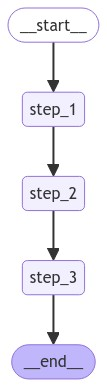

In [4]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from IPython.display import Image, display


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    # Let's optionally raise a node interrupt 
    # if the length of the input is longer than 5
    if len(state['input']) > 5:
        raise NodeInterrupt(state['input'])


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---


We can see information on what node is set to execute next, as well as what node raised the interrupt, and any information about it

In [9]:
state = graph.get_state(thread)
print(state.next)
print(state.tasks)

('step_2',)
(PregelTask(id='5bf90189-2d42-55a0-9fcc-1c897985be68', name='step_2', error=None, interrupts=(Interrupt(value='hello world', when='during'),)),)


If we try to rerun the graph... nothing has changed! So it will still interrupt!

In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

In [11]:
state = graph.get_state(thread)
print(state.next)
print(state.tasks)

('step_2',)
(PregelTask(id='5bf90189-2d42-55a0-9fcc-1c897985be68', name='step_2', error=None, interrupts=(Interrupt(value='hello world', when='during'),)),)


To get around it, we can do several things. First, we could update the state to be less thatn 5 characters long (the condition for our interrupt)

In [13]:
graph.update_state(config=thread, values={"input": "foo"})
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

---Step 3---


In [15]:
state = graph.get_state(thread)
print(state.next)
print(state.values)

()
{'input': 'foo'}


Or we could just update the state **as node_2** which would basically skip over that node

In [17]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

graph.update_state(config=thread, values=None, as_node="step_2")
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

state = graph.get_state(thread)
print(state.next)
print(state.values)

{'input': 'hello world'}
---Step 1---
---Step 3---
()
{'input': 'hello world'}
